# FVCOM Access For LOBSTER-ECOL

We need timeseries for:
 - Surface Temperature
 - Bottom Temperature
 - Bottom Salinity

For the following areas:
 - VTS Nearshore Survey Area
 - Gulf of Maine EPU
 - Georges Bank EPU

 This notebook takes a timestep of the 30-year hindcast from NECOFS and flags the nodes/edges that are within the areas we care about. These can then be exported as a csv to flag the indices we need data for when downloading from the server. 

In [6]:
# Libraries
import xarray as xr
import numpy as np
import regionmask
import geopandas as gpd
import os
from dateutil import parser
from datetime import datetime,timedelta

# Set directory of where to save a manageable piece (relative path)
print(os.getcwd())

# Path to Box Assets
box_root = "/Users/akemberling/Library/CloudStorage/Box-Box/"
sf_root = f"{box_root}/RES_Data/Shapefiles"
lob_ecol_path = f"{box_root}/Mills Lab/Projects/Lobster ECOL"

/Users/akemberling/Documents/Repositories/Lobster-ECOL/py/FVCOM-prep


## Load the Different Spatial Boundaries

<AxesSubplot:>

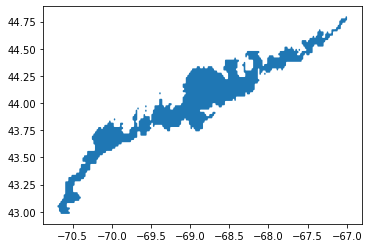

In [7]:
# Load the areas we'll crop with
gom_path = f"{sf_root}/EPU/individual_epus/GOM.geojson"
gb_path = f"{sf_root}/EPU/individual_epus/GB.geojson"
vts_path = f"{lob_ecol_path}/Ecological Data/Spatial_Boundaries/VTSsurvey_nearshore_area.geojson"
shelf_path = f"{sf_root}/EPU/EPU_extended.shp"

# Load shapez
gom_poly = gpd.read_file(gom_path)
gb_poly = gpd.read_file(gb_path)
vts_poly = gpd.read_file(vts_path)
shelf_poly = gpd.read_file(shelf_path)

# Plot one
vts_poly.plot()

## Load Some Hindcast Data

Hindcast dataset has some wonky dates so those will need to be repaired.

In [30]:
# 30-year hindcast dataset

# base url for openDAP server for 30-year hindcast
# source: http://www.smast.umassd.edu:8080/thredds/hindcasts.html?dataset=fvcom/hindcasts/30yr_gom3
url = "http://www.smast.umassd.edu:8080/thredds/dodsC/fvcom/hindcasts/30yr_gom3"

# list problematic coordinates
drop_variables = ['siglay','siglev']

# lazy load of the data
ds = xr.open_dataset(
    url,
    drop_variables = drop_variables,
    decode_times = False)

# convert lon/c, lat/c to coordinates
ds = ds.assign_coords({var:ds[var] for var in ['lon','lat','lonc','latc']})
ds

# Fix time to see what the thirty years is:

# the first day
dt0 = parser.parse(ds.time.attrs['units'].replace('days since ',''))

# parse dates summing days to the origin
ds = ds.assign(time = [dt0 + timedelta(seconds = day * 86400) for day in ds.time.values])
ds

<xarray.Dataset>
Dimensions:        (nele: 90415, node: 48451, three: 3, maxnode: 11,
                    maxelem: 9, four: 4, time: 342348, siglay: 45, siglev: 46)
Coordinates:
    lon            (node) float32 -59.89 -59.81 -59.75 ... -73.95 -73.96 -73.95
    lat            (node) float32 46.09 46.15 46.09 46.04 ... 41.62 41.62 41.62
    lonc           (nele) float32 -59.86 -59.84 -59.8 ... -73.96 -73.95 -73.95
    latc           (nele) float32 46.05 46.1 46.1 46.06 ... 41.62 41.61 41.62
  * time           (time) datetime64[ns] 1978-01-01 ... 2017-01-01
Dimensions without coordinates: nele, node, three, maxnode, maxelem, four,
                                siglay, siglev
Data variables: (12/45)
    nprocs         int32 ...
    partition      (nele) int32 ...
    x              (node) float32 ...
    y              (node) float32 ...
    xc             (nele) float32 ...
    yc             (nele) float32 ...
    ...             ...
    l              (time, siglev, node) float32 ...
    short_wave     (time, node) float32 ...
    net_heat_flux  (time, node) float32 ...
    uwind_stress   (time, nele) float32 ...
    vwind_stress   (time, nele) float32 ...
    fvcom_mesh     int32 ...
Attributes: (12/17)
    title:                       GOM3 Nesting  by Yf.Sun@umassd.edu
    institution:                 School for Marine Science and Technology
    source:                      FVCOM_3.0
    history:                     model started at: 22/12/2011   16:41
    references:                  http://fvcom.smast.umassd.edu, http://codfis...
    Conventions:                 CF-1.4, UGRID-0.9
    ...                          ...
    Surface_Heat_Forcing:        FVCOM variable surface heat forcing file:\nF...
    Surface_Wind_Forcing:        FVCOM variable surface Wind forcing:\nFILE N...
    Surface_PrecipEvap_Forcing:  FVCOM periodic surface precip forcing:\nFILE...
    cdm_data_type:               any
    DODS.strlen:                 26
    DODS.dimName:                DateStrLen

In [22]:
ds.time.values.size

342348

In [27]:
print(f"Starting Date: {ds.time.values[0]}")
print(f"Ending Date: {ds.time.values[ds.time.values.size-1]}")

Starting Date: 1978-01-01T00:00:00.000000000
Ending Date: 2017-01-01T00:00:00.000000000


## Load Essential Set of Variables

We are compute and memory limited here, so gotta leave what we don't need behind for performance

We need:
 - **lon**:      Nodal longitude
 - **lat**:      Nodal latitude
 - **lonc**:     Zonal longitude
 - **lat**:      Zonal latitude
 - **time**:     Time
 - **temp**:     Sea water temperature
 - **salinity**: Sea water salinity


We also only need surface and bottom depth, which will drop 48/50% of the size
